In [1]:
!pip install qiskit
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 96.3 MB/s eta 0:00:00


In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, partial_trace
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector
from qiskit_aer.noise import NoiseModel, depolarizing_error
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from math import log2, ceil

In [3]:
def add_classical_oracle(qc, input_qubits, output_qubit, f_table):

    n = len(input_qubits)
    for x, fx in f_table.items():
        if fx == 1:
            bits = [(x >> i) & 1 for i in range(n)][::-1]

            for qb_idx, b in zip(input_qubits, bits):
                if b == 0:
                    qc.x(qb_idx)
            if n == 1:
                qc.cx(input_qubits[0], output_qubit)
            elif n == 2:

                qc.ccx(input_qubits[0], input_qubits[1], output_qubit)
            else:
                qc.mcx(input_qubits, output_qubit)
            # undo the flips
            for qb_idx, b in zip(input_qubits, bits):
                if b == 0:
                    qc.x(qb_idx)

Bloch vector for qubit 0 AFTER initial H (before oracle):


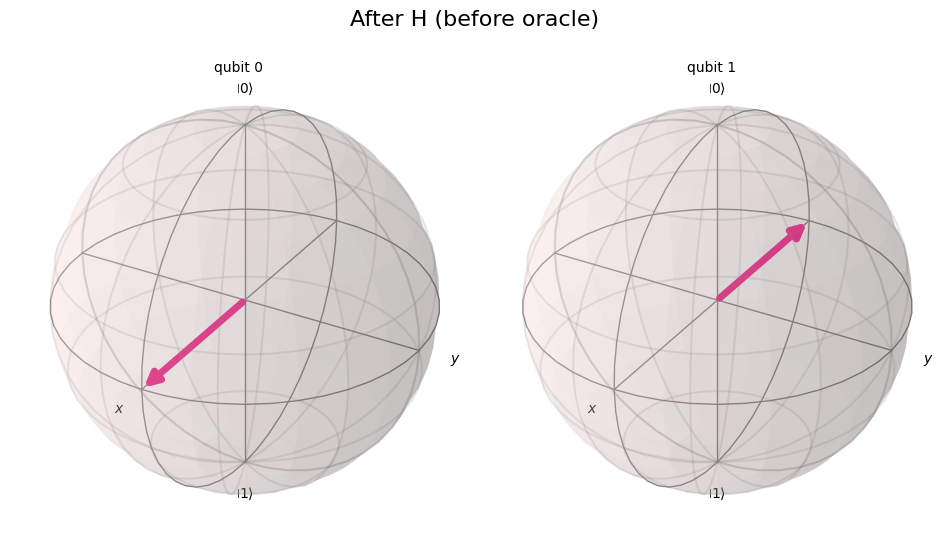

Bloch vector for qubit 0 AFTER oracle:


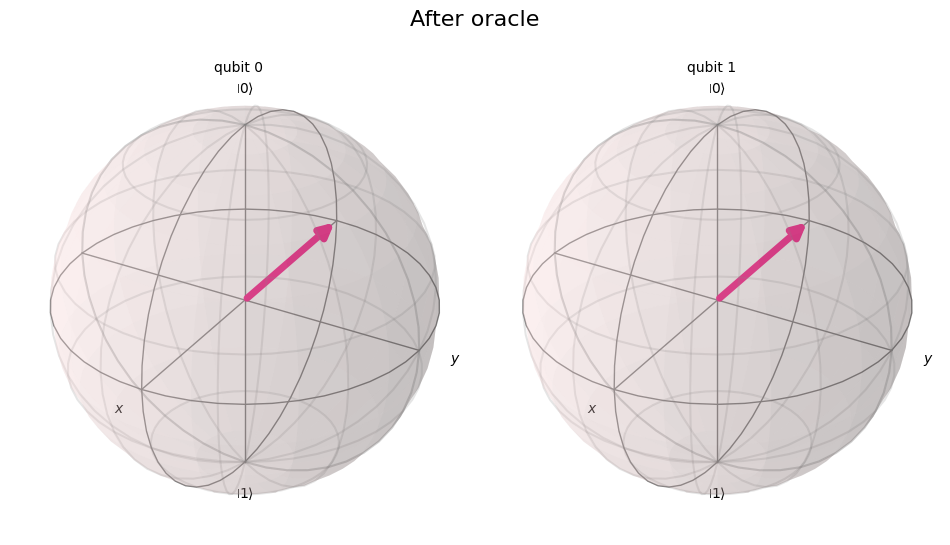

Circuit:
            ░ ┌───┐ ░ ┌───┐     ┌───┐ ░ ┌───┐┌─┐
q_0: ──────░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├┤M├
     ┌───┐ ░ ├───┤ ░ └───┘┌─┴─┐└───┘ ░ └───┘└╥┘
q_1: ┤ X ├─░─┤ H ├─░──────┤ X ├──────░───────╫─
     └───┘ ░ └───┘ ░      └───┘      ░       ║ 
c: 1/════════════════════════════════════════╩═
                                             0 
Counts (noiseless): {'1': 1024}
→ Measured 1: Algorithm declares FUNCTION IS BALANCED.


In [4]:
def deutsch_single_test():
    # prepare truth table for f(x) = x XOR 1
    f_table = {0:1, 1:0}
    qc = QuantumCircuit(2, 1)
    qc.x(1)
    qc.barrier()
    # Hadamards on both
    qc.h([0, 1])

    # Bloch of input BEFORE oracle (show single-qubit state of qubit 0)
    sv_before = Statevector(qc)
    print("Bloch vector for qubit 0 AFTER initial H (before oracle):")
    display(plot_bloch_multivector(sv_before, title="After H (before oracle)"))

    qc.barrier()
    add_classical_oracle(qc, [0], 1, f_table)

    # Bloch after oracle (global two-qubit state)
    sv_after_oracle = Statevector(qc)
    print("Bloch vector for qubit 0 AFTER oracle:")
    display(plot_bloch_multivector(sv_after_oracle, title="After oracle"))

    qc.barrier()
    qc.h(0)
    qc.measure(0, 0)


    sim = AerSimulator()
    compiled = transpile(qc, sim)
    result = sim.run(compiled).result()
    counts = result.get_counts()
    print("Circuit:\n", qc.draw(output='text'))
    print("Counts (noiseless):", counts)
    # Interpretation: '0' => constant, '1' => balanced for Deutsch
    measured = list(counts.keys())[0]
    if measured == '0':
        print("→ Measured 0: Algorithm declares FUNCTION IS CONSTANT.")
    else:
        print("→ Measured 1: Algorithm declares FUNCTION IS BALANCED.")

    return qc, f_table
qc_single, f_single = deutsch_single_test()


--- Deutsch-Jozsa n=2 tests ---

Bloch vectors after H (n=2) — BEFORE oracle:


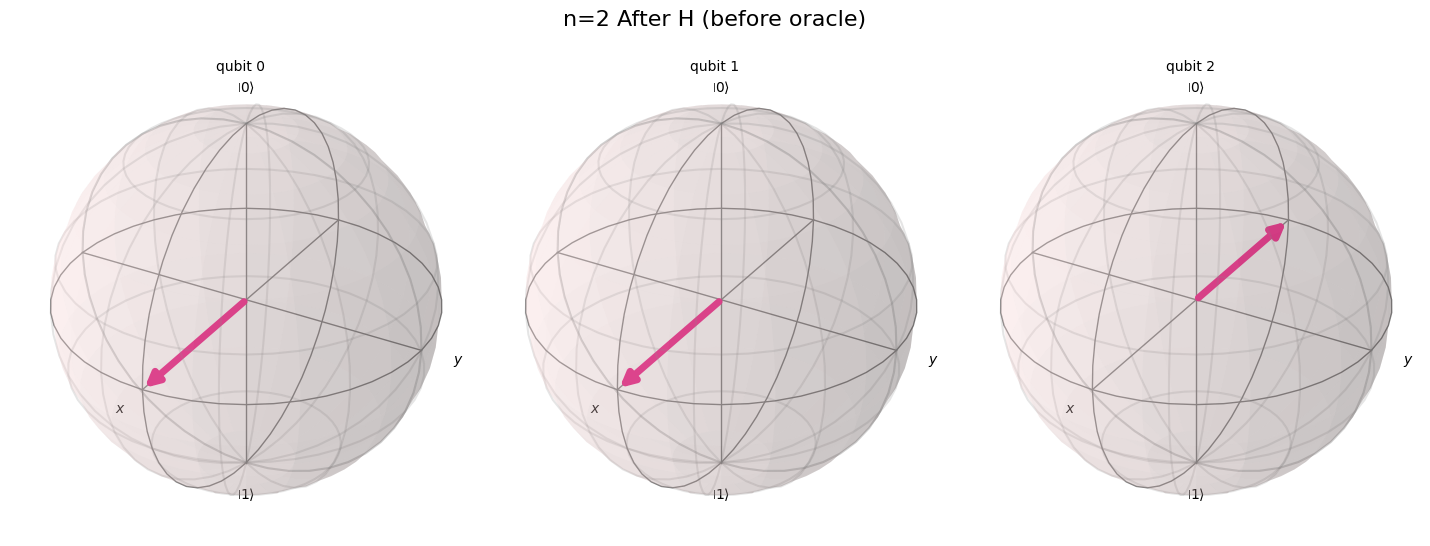


Bloch vectors AFTER oracle (n=2):


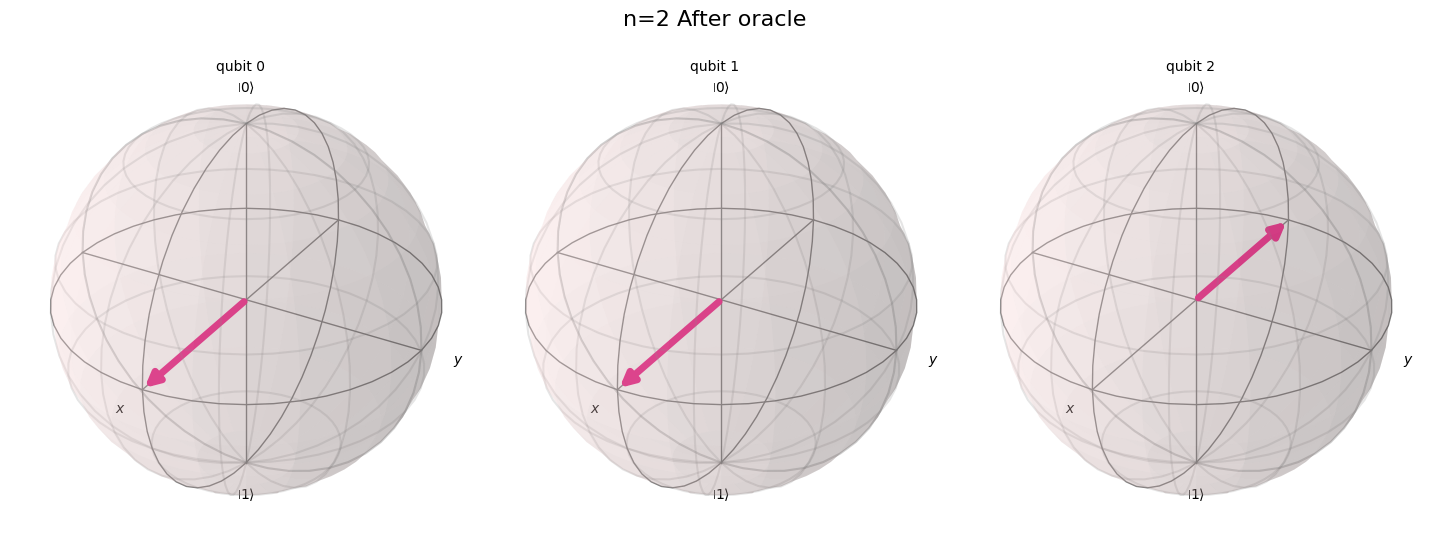

Counts: {'00': 1024}
→ Algorithm declares FUNCTION IS CONSTANT (observed all-zero).

Bloch vectors after H (n=2) — BEFORE oracle:


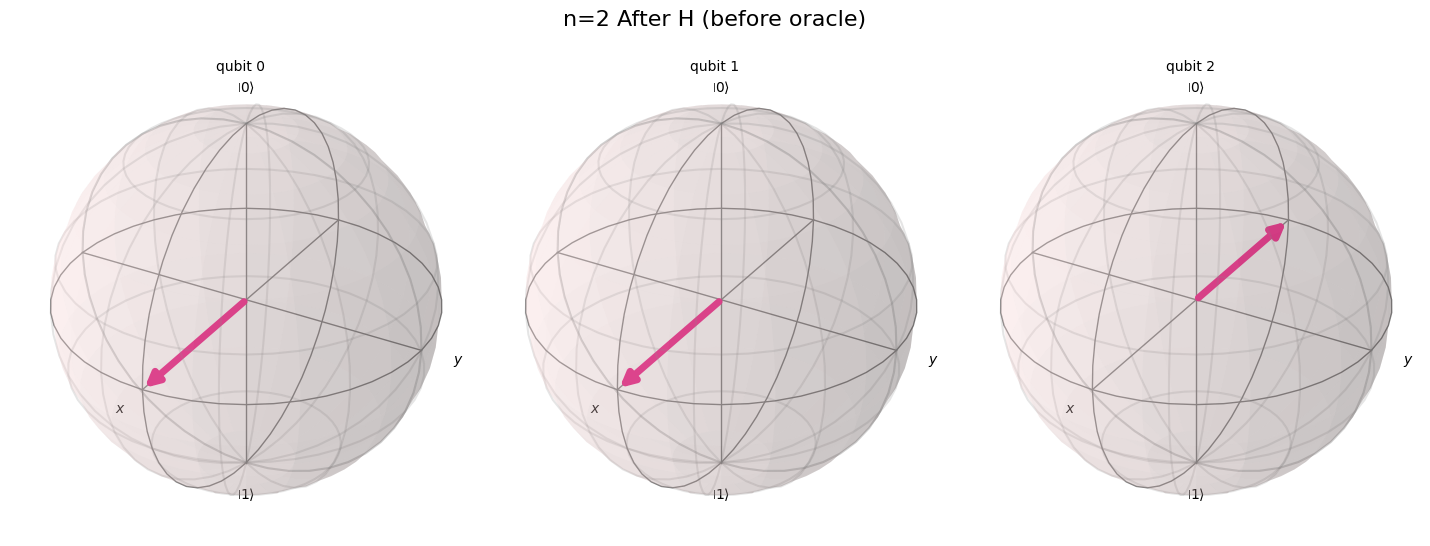


Bloch vectors AFTER oracle (n=2):


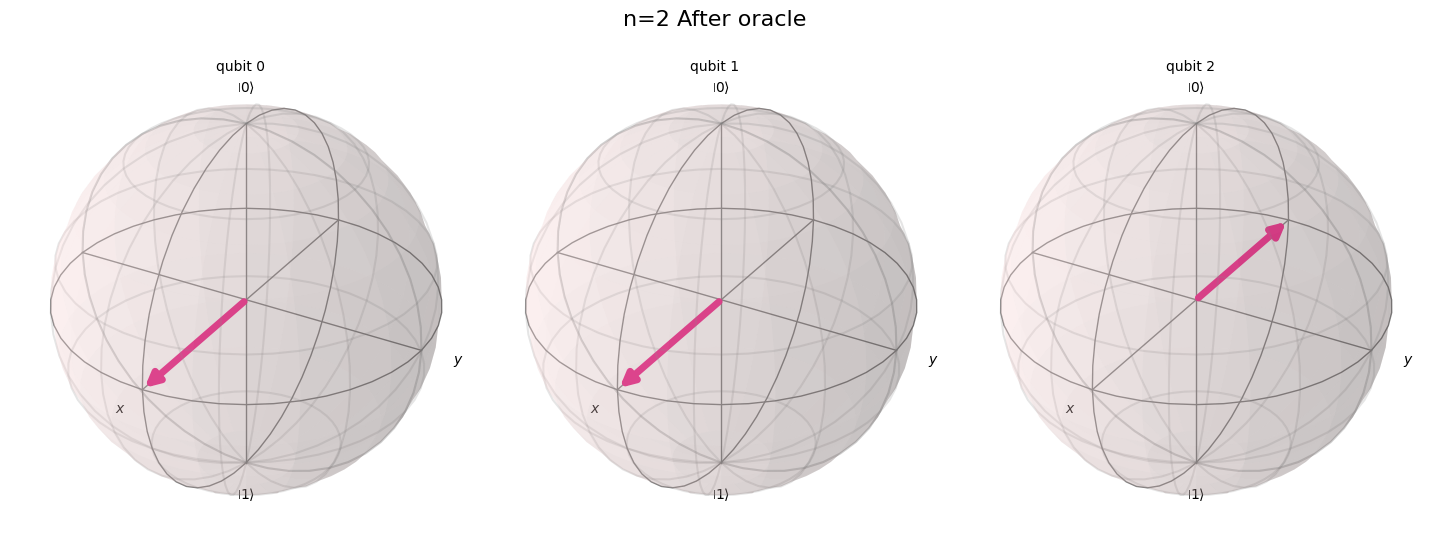

Counts: {'00': 1024}
→ Algorithm declares FUNCTION IS CONSTANT (observed all-zero).

Bloch vectors after H (n=2) — BEFORE oracle:


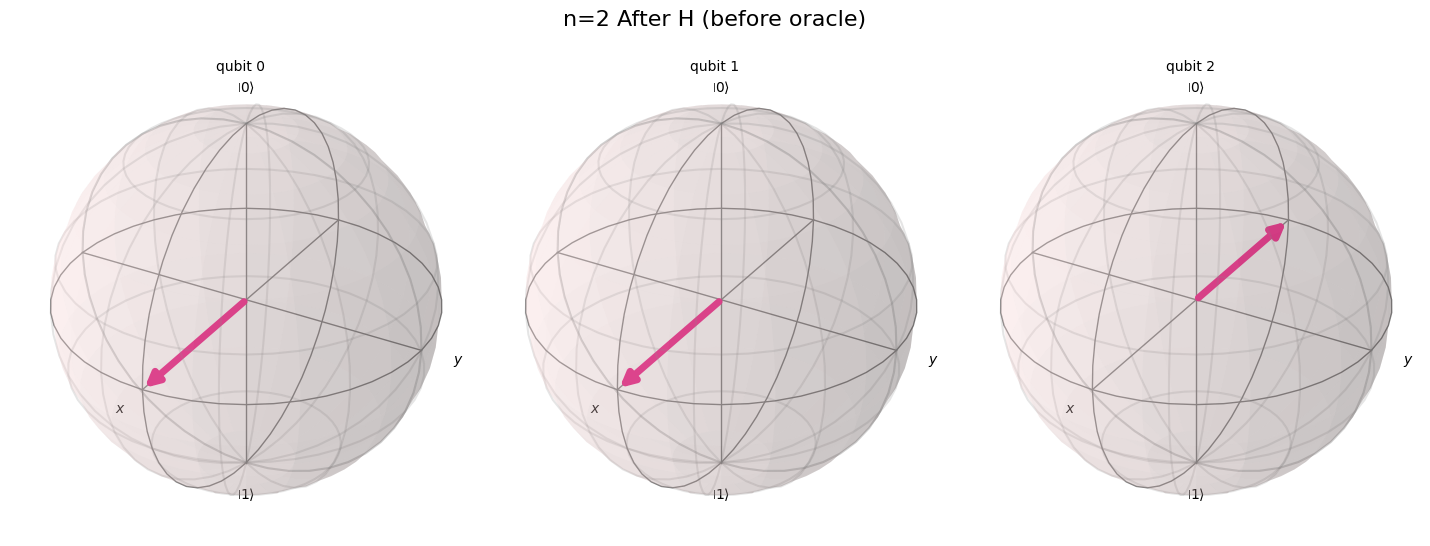


Bloch vectors AFTER oracle (n=2):


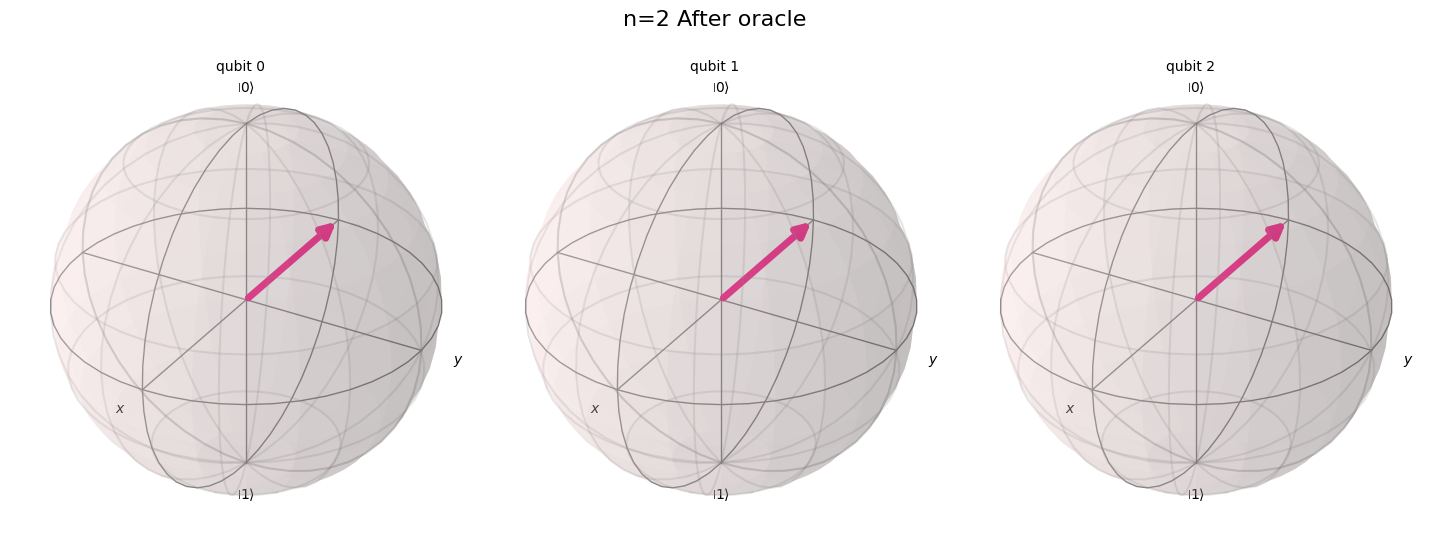

Counts: {'11': 1024}
→ Algorithm declares FUNCTION IS BALANCED (some non-zero output observed).


In [5]:
def deutsch_jozsa_run(n, f_table, shots=1024, noise_model=None):
    qc = QuantumCircuit(n + 1, n)
    input_qubits = list(range(n))
    output_qubit = n
    # Prepare output as |1>
    qc.x(output_qubit)
    qc.barrier()
    qc.h(range(n + 1))

    sv_before = Statevector(qc)
    print(f"\nBloch vectors after H (n={n}) — BEFORE oracle:")
    display(plot_bloch_multivector(sv_before, title=f"n={n} After H (before oracle)"))

    qc.barrier()
    add_classical_oracle(qc, input_qubits, output_qubit, f_table)
    sv_after = Statevector(qc)
    print(f"\nBloch vectors AFTER oracle (n={n}):")
    display(plot_bloch_multivector(sv_after, title=f"n={n} After oracle"))

    qc.barrier()
    # Hadamard on input register
    qc.h(range(n))

    for i in range(n):
        qc.measure(i, i)

    sim = AerSimulator()
    qc_comp = transpile(qc, sim)
    if noise_model is None:
        job = sim.run(qc_comp, shots=shots)
    else:
        job = sim.run(qc_comp, shots=shots, noise_model=noise_model)
    res = job.result()
    counts = res.get_counts()
    print("Counts:", counts)
    max_key = max(counts, key=counts.get)
    if max_key == '0'*n:
        print("→ Algorithm declares FUNCTION IS CONSTANT (observed all-zero).")
    else:
        print("→ Algorithm declares FUNCTION IS BALANCED (some non-zero output observed).")
    return qc, counts

# prepare sample f for n=2
# constant 0:
f_const0 = {0:0, 1:0, 2:0, 3:0}
# constant 1:
f_const1 = {0:1, 1:1, 2:1, 3:1}
f_parity = {}
for x in range(4):
    bits = [(x >> i) & 1 for i in range(2)][::-1]  # bits[0] is MSB

    fx = bits[0] ^ bits[1]
    f_parity[x] = fx

print("\n--- Deutsch-Jozsa n=2 tests ---")
qc_c0, counts_c0 = deutsch_jozsa_run(2, f_const0)
qc_c1, counts_c1 = deutsch_jozsa_run(2, f_const1)
qc_bal, counts_bal = deutsch_jozsa_run(2, f_parity)


--- Running DJ n=2 parity function on noisy simulator ---

Bloch vectors after H (n=2) — BEFORE oracle:


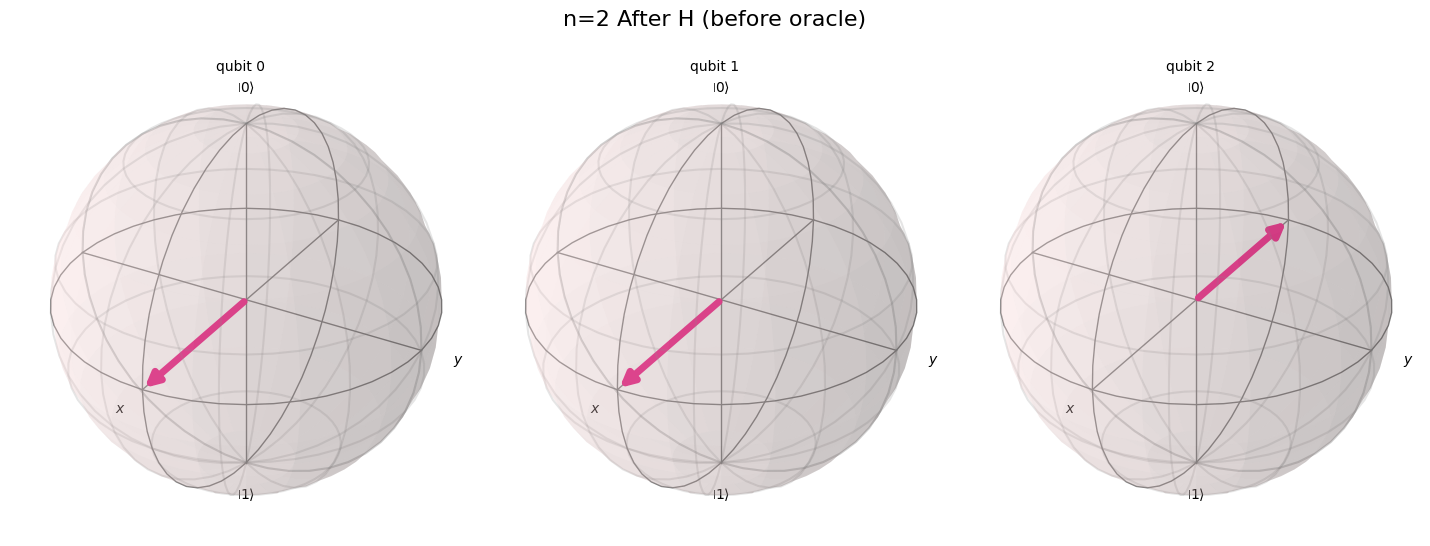


Bloch vectors AFTER oracle (n=2):


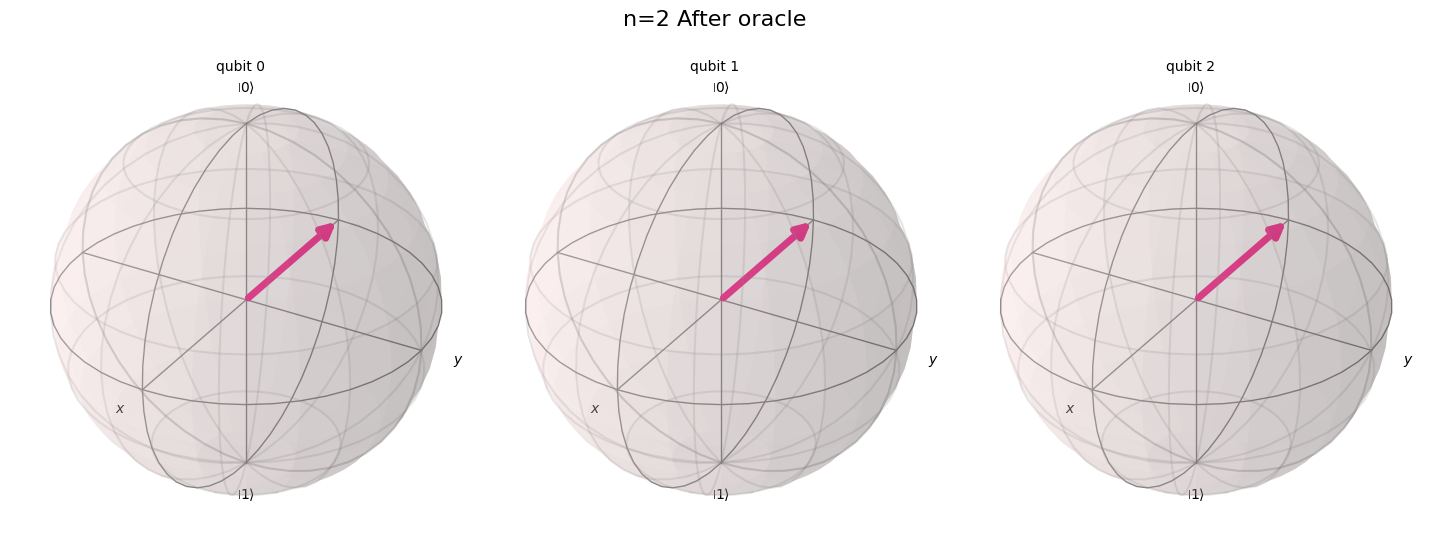

Counts: {'01': 28, '00': 18, '10': 17, '11': 1985}
→ Algorithm declares FUNCTION IS BALANCED (some non-zero output observed).

Noiseless counts for parity: {'11': 1024}
Noisy counts for parity: {'01': 28, '00': 18, '10': 17, '11': 1985}

Probability distribution (noisy):
01: 0.014
00: 0.009
10: 0.008
11: 0.969


In [6]:
#task4 noice impact
def make_simple_depolarizing_noise(p1=0.002, p2=0.02):
    noise_model = NoiseModel()
    err1 = depolarizing_error(p1, 1)
    err2 = depolarizing_error(p2, 2)
    # apply to all single-qubit gates and CX
    noise_model.add_all_qubit_quantum_error(err1, ['u', 'h', 'x'])  # 'u' covers single-qubit generic gates
    noise_model.add_all_qubit_quantum_error(err2, ['cx'])
    return noise_model

noise = make_simple_depolarizing_noise(p1=0.005, p2=0.02)
print("\n--- Running DJ n=2 parity function on noisy simulator ---")
qc_noisy, counts_noisy = deutsch_jozsa_run(2, f_parity, shots=2048, noise_model=noise)

print("\nNoiseless counts for parity:", counts_bal)
print("Noisy counts for parity:", counts_noisy)

# Analyse roughly: compute probability of all-zero vs others
def counts_to_probs(counts, shots=None):
    shots = shots if shots is not None else sum(counts.values())
    return {k: v/shots for k, v in counts.items()}

print("\nProbability distribution (noisy):")
for k, v in counts_to_probs(counts_noisy, shots=sum(counts_noisy.values())).items():
    print(f"{k}: {v:.3f}")

In [7]:
#task5
def classical_query_decider(f_table, n):
    queries = 0
    seen = {}
    for x in range(2**n):
        queries += 1
        val = f_table[x]
        seen[val] = seen.get(val, 0) + 1
        # if we have seen both 0 and 1, we can stop (balanced)
        if 0 in seen and 1 in seen:
            return queries, 'balanced'
    # exhausted all inputs and saw only one value -> constant
    return queries, 'constant'

# Example classical counts:
print("\n--- Classical queries needed (deterministic) ---")
q_single, res_single = classical_query_decider(f_single, 1)
print(f"Single-qubit f(x)=x XOR 1: queries needed = {q_single}, decision = {res_single} (quantum used 1 query).")

q_c2_const, res_c2_const = classical_query_decider(f_const0, 2)
q_c2_par, res_c2_par = classical_query_decider(f_parity, 2)
print(f"n=2 constant_0: queries needed = {q_c2_const}, decision = {res_c2_const}.")
print(f"n=2 parity balanced: queries needed = {q_c2_par}, decision = {res_c2_par}.")


--- Classical queries needed (deterministic) ---
Single-qubit f(x)=x XOR 1: queries needed = 2, decision = balanced (quantum used 1 query).
n=2 constant_0: queries needed = 4, decision = constant.
n=2 parity balanced: queries needed = 2, decision = balanced.
